In [12]:
!pip install pennylane
!pip install pennylane-qiskit
!pip install qiskit
!pip install qml
!pip install cv2
#!pip install tensorflow-macos

  Using cached qml-0.4.0.27.tar.gz (41 kB)
  Running setup.py clean for qml
Failed to build qml
    Running setup.py install for qml: started
    Running setup.py install for qml: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\gueha\anaconda3\envs\quantum\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\gueha\\AppData\\Local\\Temp\\pip-install-9q3w5heu\\qml_d97473a1455f47849a46bc6fd263a8a3\\setup.py'"'"'; __file__='"'"'C:\\Users\\gueha\\AppData\\Local\\Temp\\pip-install-9q3w5heu\\qml_d97473a1455f47849a46bc6fd263a8a3\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\gueha\AppData\Local\Temp\pip-wheel-qon3mhtr'
       cwd: C:\Users\gueha\AppData\Local\Temp\pip-install-9q3w5heu\qml_d97473a1455f47849a46bc6fd263a8a3\
  Complete output (69 lines):
  MKL-discover: MKLROOT was not set
  running bdist_wheel
  running build
  running config_cc
  INFO: unifing con

In [2]:
import warnings

#import pickle
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import scipy
from scipy.io import wavfile

import librosa
import librosa.display

import time as ti

import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers  import Conv2D, MaxPooling2D, Dense,Flatten, GRU, BatchNormalization, Conv1D, Dropout, Bidirectional,MaxPooling1D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, BatchNormalization, Conv1D, GRU, TimeDistributed, Activation, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy

import qiskit
import qiskit.providers.aer.noise as noise
from qiskit import IBMQ

## Local Definition 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
noise_mode = True # for running at QPU

n_w = 2 # numbers of wires def 2

if  noise_mode == True:
    #dev = qml.device('qiskit.aer', wires= n_w, noise_model=noise_model)
    #dev = qml.device('qiskit.ibmq', wires=n_w, backend='ibmq_qasm_simulator', provider=provider)
    dev = qml.device("default.mixed", wires= n_w)
else:
    #local quantum simulator
    dev = qml.device("default.qubit", wires= n_w)
    

In [4]:
n_layers = 1

# Random circuit parameters
rand_params1 = np.random.uniform(high= 2 * np.pi, size=(n_layers, n_w)) # def 2, n_w = 4

In [5]:
@qml.qnode(dev)
def circuit(p=0.01,phi=None):
    # Encoding of 4 classical input values
    for j in range(n_w):
        qml.RY(np.pi * phi[j], wires=j)
        qml.DepolarizingChannel(p, wires=j)

    # Random quantum circuit
    RandomLayers(rand_params1, wires=list(range(n_w)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_w)]

In [38]:
def quanv(image, kr=2, p=0.01):
    h_feat, w_feat, ch_n = image.shape
    #h_feat=image.shape[0]
    #w_feat=image.shape[1]
    #ch_n=image.shape[2]
    """Convolves the input speech with many applications of the same quantum circuit."""
    out = np.zeros((h_feat//kr, w_feat//kr, n_w))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, h_feat-1, kr):
        for k in range(0, w_feat-1, kr):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                p,
                # kernal 3 ## phi=[image[j, k, 0], image[j, k + 1, 0], image[j, k + 2, 0], image[j + 1, k, 0], 
                # image[j + 1, k + 1, 0], image[j + 1, k +2 , 0],image[j+2, k, 0], image[j+2, k+1, 0], image[j+2, k+2, 0]]
                phi=[image[j, k, 0], image[j, k + 1, 0], image[j + 1, k, 0], image[j + 1, k + 1, 0]]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(n_w):
                out[j // kr, k // kr, c] = q_results[c]
    return out

In [42]:
#want to change eps, bsize, sr to optimize
eps = 75
bsize = 16
sr = 48000
net = 1
mel = 1
quanv_mode = 1
# Quantum Layers
ql0 = 1
ql1 = 1
ql2 = 1
ql3 = 1
ql4 = 1
port = 1
labels = [
    'hwan'
]
data_ix = ti.strftime("%m%d_%H%M")
SAVE_PATH = "hwan_quantum/" # Data saving folder
#train_audio_path = '/content/drive/My Drive/QuantumTeams/Pennylane Speech'
train_audio_path = './'

In [43]:
import numpy as np
import cv2
qtrain = []

for label in tqdm(labels):
    imgFiles = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.jpg')]
    for num, imgFile in enumerate(imgFiles, 0):
        img = cv2.imread(train_audio_path + '/' + label + '/' + imgFile)
        qtrain.append(quanv(img, 2, 0))
    q_train = np.asarray(qtrain)

100%|██████████| 1/1 [09:26<00:00, 566.55s/it]


In [58]:
q_train = np.asarray(qtrain)

In [59]:
print(q_train.shape)

(6, 192, 272, 2)


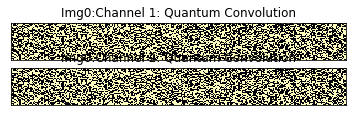

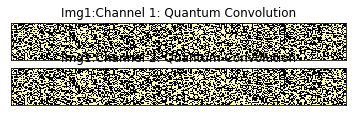

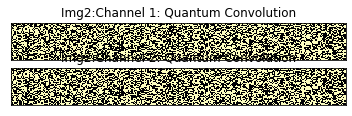

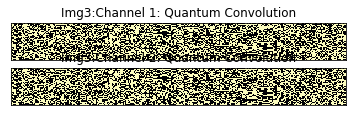

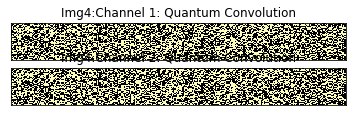

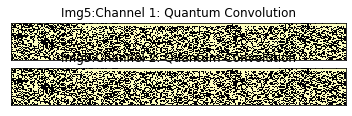

In [64]:
for j in range(6):
    plt.figure()
    for i in range(2):
        plt.subplot(5, 1, i+2)
        librosa.display.specshow(librosa.amplitude_to_db(q_train[j,:,:,i], ref=np.max))
        plt.title('Img'+str(j)+':Channel '+str(i+1)+': Quantum Convolution')

In [ ]:
def gen_qspeech(x_train, x_valid, kr, p=0.01): # kernal size = 2x2 or 3x3
    q_train = []
    print("Quantum pre-processing of train Speech:")
    for idx, img in enumerate(x_train):
        print("{}/{}        ".format(idx + 1, len(x_train)), end="\r")
        q_train.append(quanv(img, kr, p))
    q_train = np.asarray(q_train)

    q_valid = []
    print("\nQuantum pre-processing of test Speech:")
    for idx, img in enumerate(x_valid):
        print("{}/{}        ".format(idx + 1, len(x_valid)), end="\r")
        q_valid.append(quanv(img, kr))
    q_valid = np.asarray(q_valid)
    
    return q_train, q_valid

In [ ]:
def plot_acc_loss(q_history0, q_history1, q_history2, q_history3, q_history4):

    plt.figure()
    plt.style.use("seaborn")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

    ax1.plot(q_history0.history["accuracy"], "-or", label="with p=0")
    ax1.plot(q_history1.history["accuracy"], "-ok", label="with p=0.001")
    ax1.plot(q_history2.history["accuracy"], "-ob", label="with p=0.01")
    ax1.plot(q_history3.history["accuracy"], "-og", label="with p=0.1")
    ax1.plot(q_history4.history["accuracy"], "-oy", label="with p=0.2")
    ax1.set_ylabel("Train Accuracy")
    ax1.set_ylim([0, 1.2])
    ax1.set_xlabel("Epoch")
    ax1.legend()

    ax2.plot(q_history0.history["val_accuracy"], "-or", label="with p=0")
    ax2.plot(q_history1.history["val_accuracy"], "-ok", label="with p=0.001")
    ax2.plot(q_history2.history["val_accuracy"], "-ob", label="with p=0.01")
    ax2.plot(q_history3.history["val_accuracy"], "-og", label="with p=0.1")
    ax2.plot(q_history4.history["val_accuracy"], "-oy", label="with p=0.2")
    ax2.set_ylabel("Test Accuracy")
    ax1.set_ylim([0, 1.2])
    #ax2.set_ylim(top=5.5)
    ax2.set_xlabel("Epoch")
    ax2.legend()
    plt.tight_layout()
    #plt.savefig("images/"+ data_ix +"_conv_speech_loss.png")

In [ ]:
def show_speech(x_train, q_train, use_ch, idx, tmp = "tmp"):
    plt.figure()
    plt.subplot(5, 1, 1)
    if use_ch != True:
        librosa.display.specshow(librosa.power_to_db(x_train[idx,:,:,0], ref=np.max))
    else:
        librosa.display.specshow(librosa.power_to_db(x_train[idx,:,:], ref=np.max))
    plt.title('Input Speech: ' + tmp)

    for i in range(4):
        plt.subplot(5, 1, i+2)
        librosa.display.specshow(librosa.power_to_db(q_train[idx,:,:,i], ref=np.max))
        plt.title('Channel '+str(i+1)+': Quantum Compressed Speech')


    plt.tight_layout()
    plt.savefig("images/speech_encoder_" + tmp + ".png")

In [ ]:
def show_stft_speech(x_train, q_train, use_ch, idx, tmp = "tmp"):
    plt.figure()
    plt.subplot(5, 1, 1)
    if use_ch != True:
        librosa.display.specshow(librosa.amplitude_to_db(x_train[idx,:,:,0], ref=np.max))
    else:
        librosa.display.specshow(librosa.amplitude_to_db(x_train[idx,:,:,0], ref=np.max))
    plt.title('Input Speech: ' + tmp)
    
    for i in range(4):
        plt.subplot(5, 1, i+2)
        librosa.display.specshow(librosa.amplitude_to_db(q_train[idx,:,:,1], ref=np.max))
        plt.title('Channel '+str(i+1)+': Quantum Compressed Speech')


In [ ]:
def dense_Model(x, labels):
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    if len(x.shape) >= 3:
        h_feat,w_feat,ch_size = x.shape
        input_layer = keras.layers.Input(shape=(h_feat,w_feat,ch_size))
    else:
        h_feat,w_feat = x.shape
        input_layer = keras.layers.Input(shape=(h_feat,w_feat))
    model = keras.models.Sequential([
        input_layer,
        keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True),
        keras.layers.Flatten(),
        keras.layers.Dense(64),
        keras.layers.Dense(64),
        keras.layers.Dense(32),
        keras.layers.Dense(len(labels), activation="softmax")
    ])

    model.compile(
        optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
# define cnn model
def cnn_Model(h_feat, w_feat, labels):       
	model = Sequential()
	model.add(Conv2D(6, (2, 2), padding='valid', activation='relu', input_shape=(h_feat, w_feat, 1)))
	#model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(len(labels), activation='softmax'))
	# compile model
	opt = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
def attrnn_Model(x_in, labels, use_cnn=False, ablation = False):
    # simple LSTM
    rnn_func = L.LSTM
    use_Unet = True

    if len(x_in.shape) >= 3:
        h_feat,w_feat,ch_size = x_in.shape
        inputs = keras.layers.Input(shape=(h_feat, w_feat, ch_size))
    else:
        h_feat, w_feat = x_in.shape
        inputs = keras.layers.Input(shape=(h_feat, w_feat))

    inputs = L.Input(shape=(h_feat, w_feat, ch_size))

    if use_cnn == True:
        #x = L.Permute((2, 1, 3))(inputs)
        # First conv block
        x = L.Conv2D(
            32,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            name="Conv1",
        )(inputs)
        x = L.MaxPooling2D((2, 2), name="pool1")(x)

        # Second conv block
        x = L.Conv2D(
            64,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            name="Conv2",
        )(x)
        x = L.MaxPooling2D((2, 2), name="pool2")(x)
    else:
        x=inputs
        
    if ablation == True:
        x = L.Conv2D(4, (1, 1), strides=(2, 2), activation='relu', padding='same', name='abla_conv')(x)
        x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)
    else:
        x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

    # note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    # we would rather have it the other way around for LSTMs

    x = L.Permute((2, 1, 3))(x)

    if use_Unet == True:
        x = L.Conv2D(16, (5, 1), activation='relu', padding='same', name='ConvUp')(x)
        up = L.BatchNormalization()(x)
        x = L.Conv2D(32, (5, 1), activation='relu', padding='same', name='ConvDown1')(up)
        x = L.BatchNormalization()(x)
        x = L.Conv2D(16, (5, 1), activation='relu', padding='same', name='ConvDown2')(x)
        down = L.BatchNormalization()(x)
        merge = L.Concatenate(axis=3)([up,down])
        x = L.Conv2D(1, (5, 1), activation='relu', padding='same', name='ConvMerge')(merge)
        x = L.BatchNormalization()(x)
    else:
        x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
        x = L.BatchNormalization()(x)
        x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
        x = L.BatchNormalization()(x)

    x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)


    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]
    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]

    xFirst = L.Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
    query = L.Dense(128)(xFirst)

    # dot product attention
    attScores = L.Dot(axes=[1, 2])([query, x])
    attScores = L.Softmax(name='attSoftmax')(attScores)  # [b_s, seq_len]

    # rescale sequence
    attVector = L.Dot(axes=[1, 1])([attScores, x])  # [b_s, vec_dim]

    x = L.Dense(64, activation='relu')(attVector)
    x = L.Dense(32)(x)

    output = L.Dense(len(labels), activation='softmax', name='output')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [ ]:
#%cd speech_quantum_dl
#from google.colab import drive

#drive.mount('/content/drive/', force_remount=True)
#%cd '/content/drive/My Drive/QuantumTeams/Pennylane Speech/'
#from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
#!cd /content/drive/My\ Drive/Michael\ COVID\ audio\ data


In [ ]:
data_ix = ti.strftime("%m%d_%H%M")
SAVE_PATH = "data_quantum/" # Data saving folder
#train_audio_path = '/content/drive/My Drive/QuantumTeams/Pennylane Speech'
train_audio_path = './'

In [ ]:
def gen_mel(labels, train_audio_path, sr, port):
    all_wave = []
    all_label = []
    maxL=0
    minL=358321
    for label in tqdm(labels):
        waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
        for num, wav in enumerate(waves, 0):
            #print(wav)
            y, _ = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = sr)
            if len(y)>maxL:
                maxL =len(y)
            if len(y)<minL:
                minL =len(y)
            if num % port ==0:   # take 1/port samples
                if(len(y)>= 32000) :
                    mel_feat = librosa.feature.melspectrogram(y=y[0:32000], sr=sr, n_fft=1024, hop_length=128, center=True, power=1.0, n_mels=60, fmin=40.0, fmax=sr/2) #y[0:sr]
                    all_wave.append(np.expand_dims(mel_feat, axis=2))
                    all_label.append(label)
    print(maxL)
    print(minL)
    return all_wave, all_label

In [ ]:
def gen_stft(labels, train_audio_path, sr, port):
    all_wave = []
    all_label = []
    windowLength = 1024
    window = scipy.signal.hamming(windowLength, sym=False)
    overlap      = round(0.25 * windowLength) # overlap of 75%
    for label in tqdm(labels):
        waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
        for num, wav in enumerate(waves, 0):
            y, _ = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = sr)
            if num % port ==0:   # take 1/port samples
                if(len(y)== sr) :
                    stft_feat = librosa.stft(y, n_fft=windowLength, win_length=windowLength, hop_length=128,
                            window=window, center=True)
                    all_wave.append(np.expand_dims(stft_feat, axis=2))
                    all_label.append(label)
    
    return all_wave, all_label

In [ ]:
#want to change eps, bsize, sr to optimize
eps = 75
bsize = 16
sr = 48000
net = 1
mel = 1
quanv_mode = 1
# Quantum Layers
ql0 = 1
ql1 = 1
ql2 = 1
ql3 = 1
ql4 = 1
port = 1
labels = [
    'covid_segment','healthy_segment'
]

In [ ]:
def gen_train(labels, train_audio_path, sr, port):
    all_wave, all_label = gen_mel(labels, train_audio_path, sr, port)
    #all_wave, all_label = gen_stft(labels, train_audio_path, sr, port)

    label_enconder = LabelEncoder()
    y = label_enconder.fit_transform(all_label)
    classes = list(label_enconder.classes_)
    y = keras.utils.to_categorical(y, num_classes=len(labels))

    from sklearn.model_selection import train_test_split
    x_train, x_valid, y_train, y_valid = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)
    h_feat, w_feat, _ = x_train[0].shape
    np.save(SAVE_PATH + "x_train_speech.npy", x_train)
    np.save(SAVE_PATH + "x_test_speech.npy", x_valid)
    np.save(SAVE_PATH + "y_train_speech.npy", y_train)
    np.save(SAVE_PATH + "y_test_speech.npy", y_valid)
    print("===== Shape", h_feat, w_feat)

    return x_train, x_valid, y_train, y_valid

In [ ]:
def gen_quanv(x_train, x_valid, kr, p, n_w):
    print("Kernal = ", kr)
    q_train, q_valid = gen_qspeech(x_train, x_valid, kr, p)

    np.save(SAVE_PATH + str(n_w)+str(p) + "n_q_train_speech.npy", q_train)
    np.save(SAVE_PATH + str(n_w)+str(p) + "n_q_test_speech.npy", q_valid)

    return q_train, q_valid

In [ ]:
if mel == 1:
    x_train, x_valid, y_train, y_valid = gen_train(labels, train_audio_path, sr, port) 
else:
    x_train = np.load(SAVE_PATH + "x_train_speech.npy")
    x_valid = np.load(SAVE_PATH + "x_test_speech.npy")
    y_train = np.load(SAVE_PATH + "y_train_speech.npy")
    y_valid = np.load(SAVE_PATH + "y_test_speech.npy")

In [ ]:
print("Xtrain len:", len(x_train))
print("XValid len:", len(x_valid))

zero_val = 0
one_val = 0
for i in y_valid:
    # get(key, default) falls back to default if key is not present
    if i[1] == 1:
        one_val = one_val + 1
    else:
        zero_val = zero_val + 1

print("Valid count")
print("Healthy:", one_val)
print("Covid:", zero_val)
print("Total:", one_val+zero_val)

zero_val = 0
one_val = 0
for i in y_train:
    # get(key, default) falls back to default if key is not present
    if i[1] == 1:
        one_val = one_val + 1
    else:
        zero_val = zero_val + 1

print("Train count")
print("Healthy:", one_val)
print("Covid:", zero_val)
print("Total:", one_val+zero_val)

In [ ]:
plt.figure()
plt.imshow(librosa.power_to_db(x_train[0,:,:,0], ref=np.max))
plt.xticks([])
plt.yticks([])

In [ ]:
if quanv_mode == 1:
    if ql0 == 1:
        q_train20, q_valid20 = gen_quanv(x_train, x_valid, 2, 0, 2) 
    if ql1 == 1:
        q_train21, q_valid21 = gen_quanv(x_train, x_valid, 2,0.001, 2) 
    if ql2 == 1:
        q_train22, q_valid22 = gen_quanv(x_train, x_valid, 2,0.01, 2)
    if ql3 == 1:
        q_train23, q_valid23 = gen_quanv(x_train, x_valid, 2,0.1, 2) 
    if ql4 == 1:
        q_train24, q_valid24 = gen_quanv(x_train, x_valid, 2,0.2, 2) 
else:
    if ql0 == 1:
        q_train20 = np.load(SAVE_PATH + "20n_q_train_speech.npy")
        q_valid20 = np.load(SAVE_PATH + "20n_q_test_speech.npy")
    if ql1 == 1:
        q_train21 = np.load(SAVE_PATH + "20.001_q_train_speech.npy")
        q_valid21 = np.load(SAVE_PATH + "20.001_q_test_speech.npy")
    if ql2 == 1:
        q_train22 = np.load(SAVE_PATH + "20.01_q_train_speech.npy")
        q_valid22 = np.load(SAVE_PATH + "20.01n_q_test_speech.npy")
    if ql3 == 1:
        q_train23 = np.load(SAVE_PATH + "20.1n_q_train_speech.npy")
        q_valid23 = np.load(SAVE_PATH + "20.1n_q_test_speech.npy")
    if ql4 == 1:
        q_train24 = np.load(SAVE_PATH + "20.2n_q_train_speech.npy")
        q_valid24 = np.load(SAVE_PATH + "20.2n_q_test_speech.npy")


In [ ]:
n_w = 4 # numbers of wires def 2

if  noise_mode == True:
    #dev = qml.device('qiskit.aer', wires= n_w, noise_model=noise_model)
    #dev = qml.device('qiskit.ibmq', wires=n_w, backend='ibmq_qasm_simulator', provider=provider)
    dev = qml.device("default.mixed", wires= n_w)
else:
    #local quantum simulator
    dev = qml.device("default.qubit", wires= n_w)

In [ ]:
n_layers = 1

# Random circuit parameters
rand_params1 = np.random.uniform(high= 2 * np.pi, size=(n_layers, n_w)) # def 2, n_w = 4

In [ ]:
@qml.qnode(dev)
def circuit2(p=0.01,phi=None):
    # Encoding of 4 classical input values
    for j in range(n_w):
        qml.RY(np.pi * phi[j], wires=j)
        qml.DepolarizingChannel(p, wires=j)

    # Random quantum circuit
    RandomLayers(rand_params1, wires=list(range(n_w)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_w)]

In [ ]:
def quanv2(image, kr=2, p=0.01):
    h_feat, w_feat, ch_n = image.shape
    """Convolves the input speech with many applications of the same quantum circuit."""
    out = np.zeros((h_feat//kr, w_feat//kr, n_w))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, h_feat-1, kr):
        for k in range(0, w_feat-1, kr):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit2(
                p,
                # kernal 3 ## phi=[image[j, k, 0], image[j, k + 1, 0], image[j, k + 2, 0], image[j + 1, k, 0], 
                # image[j + 1, k + 1, 0], image[j + 1, k +2 , 0],image[j+2, k, 0], image[j+2, k+1, 0], image[j+2, k+2, 0]]
                phi=[image[j, k, 0], image[j, k + 1, 0], image[j + 1, k, 0], image[j + 1, k + 1, 0]]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(n_w):
                out[j // kr, k // kr, c] = q_results[c]
    return out

In [ ]:
def gen_qspeech2(x_train, x_valid, kr, p=0.01): # kernal size = 2x2 or 3x3
    q_train = []
    print("Quantum pre-processing of train Speech:")
    for idx, img in enumerate(x_train):
        print("{}/{}        ".format(idx + 1, len(x_train)), end="\r")
        q_train.append(quanv2(img, kr, p))
    q_train = np.asarray(q_train)

    q_valid = []
    print("\nQuantum pre-processing of test Speech:")
    for idx, img in enumerate(x_valid):
        print("{}/{}        ".format(idx + 1, len(x_valid)), end="\r")
        q_valid.append(quanv2(img, kr))
    q_valid = np.asarray(q_valid)
    
    return q_train, q_valid

In [ ]:
def gen_quanv2(x_train, x_valid, kr, p, n_w):
    print("Kernal = ", kr)
    q_train, q_valid = gen_qspeech2(x_train, x_valid, kr, p)

    np.save(SAVE_PATH + str(n_w)+str(p) + "n_q_train_speech.npy", q_train)
    np.save(SAVE_PATH + str(n_w)+str(p) + "n_q_test_speech.npy", q_valid)

    return q_train, q_valid

In [ ]:
if quanv_mode == 1:
    if ql0 == 1:
        q_train40, q_valid40 = gen_quanv2(x_train, x_valid, 2, 0, 4) 
    if ql1 == 1:
        q_train41, q_valid41 = gen_quanv2(x_train, x_valid, 2,0.001, 4) 
    if ql2 == 1:
        q_train42, q_valid42 = gen_quanv2(x_train, x_valid, 2,0.01, 4)
    if ql3 == 1:
        q_train43, q_valid43 = gen_quanv2(x_train, x_valid, 2,0.1, 4) 
    if ql4 == 1:
        q_train44, q_valid44 = gen_quanv2(x_train, x_valid, 2,0.2, 4) 
else:
    if ql0 == 1:
        q_train40 = np.load(SAVE_PATH + "40n_q_train_speech.npy")
        q_valid40 = np.load(SAVE_PATH + "40n_q_test_speech.npy")
    if ql1 == 1:
        q_train41 = np.load(SAVE_PATH + "40.001_q_train_speech.npy")
        q_valid41 = np.load(SAVE_PATH + "20.001_q_test_speech.npy")
    if ql2 == 1:
        q_train42 = np.load(SAVE_PATH + "40.01_q_train_speech.npy")
        q_valid42 = np.load(SAVE_PATH + "40.01n_q_test_speech.npy")
    if ql3 == 1:
        q_train43 = np.load(SAVE_PATH + "40.1n_q_train_speech.npy")
        q_valid43 = np.load(SAVE_PATH + "40.1n_q_test_speech.npy")
    if ql4 == 1:
        q_train44 = np.load(SAVE_PATH + "40.2n_q_train_speech.npy")
        q_valid44 = np.load(SAVE_PATH + "40.2n_q_test_speech.npy")


In [ ]:
def search(list, platform):
    for i in range(len(list)):
        if list[i] == platform:
            return True
    return False

In [ ]:
def searchIndex(list, platform):
    for i in range(len(list)):
        if list[i] == platform:
            return i
    return -1

In [ ]:
#idx=[]
#thislist = []
#ii = 0
#for jj in range(len(y_train)):
#    label=labels[searchIndex(y_train[jj],1)]
#    if search(thislist, label) == False:
#        thislist.append(label)
#        print(label)
#        idx.append(jj)

In [ ]:
#librosa.amplitude_to_db(q_train1[2,:,:,1], ref=np.max)

In [ ]:
#plt.figure()
#for i in range(4):
#    plt.subplot(5, 1, i+2)
#    librosa.display.specshow(librosa.amplitude_to_db(q_train1[0,:,:,1], ref=np.max))
#    plt.title('Channel '+str(i+1)+': Quantum Compressed Speech')

In [ ]:
#S_db=librosa.amplitude_to_db(x_train[0,:,:,0],ref=np.max)
#plt.figure()
#librosa.display.specshow(S_db)
#plt.colorbar()

In [ ]:
#for jj in range(len(idx)):
    #show_speech(x_train, q_train, False, idx[jj], tmp = labels[searchIndex(y_train[jj],1)])
    #show_stft_speech(x_train, q_train, False, idx[jj], tmp = labels[searchIndex(y_train[jj],1)])

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 15})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.title(title)
    plt.show()
    #%%

In [ ]:
import IPython.display as ipd
import scipy
window = scipy.signal.hamming(1024, sym=False)

rev3 = librosa.feature.inverse.mel_to_audio(x_train[0,:,:,0], sr=sr, n_fft=1024,
                                                    hop_length=128,
                                                    win_length=1024, window=window,
                                                    center=True, pad_mode='reflect', power=1.0, n_iter=32, length=None)

ipd.Audio(data=rev3, rate=sr) # load a local WAV file

In [ ]:
!pip install keras

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
## For Quanv Exp.
early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                           verbose=1, patience=10, min_delta=0.0001)

checkpoint = ModelCheckpoint('checkpoints/best_base_demo2.hdf5', monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')

if net == 0:
    modelx = dense_Model(x_train[0], labels)
elif net == 1:
    modelx = attrnn_Model(x_train[0], labels)

modelx.summary()

x_history = modelx.fit(
    x=x_train, 
    y=y_train,
    epochs=eps, 
    callbacks=[checkpoint], 
    batch_size=bsize, 
    validation_data=(x_valid,y_valid)
)


keras.models.save_model(modelx, 'checkpoints/'+ data_ix + '_base_model_demo2.hdf5') 
modelx.save('checkpoints/'+ data_ix + '_base_demo2.hdf5')

print("=== Batch Size: ", bsize)

In [ ]:
y_test=np.argmax(y_valid, axis=1)

In [ ]:
y_pred=modelx.predict(x_valid)
y_pred1 = (y_pred > 0.5) 
y_pred=modelx.predict(x_train)
y_pred2 = (y_pred > 0.5) 

y_pred=np.argmax(y_pred1, axis=1)
print('\Base Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
print('\Base Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
cm = metrics.confusion_matrix(y_test, y_pred)


plot_confusion_matrix(cm , 
                      normalize    = False,
                      target_names = labels,
                      title        = "Baseline Confusion Matrix")

In [ ]:
modelx=keras.models.load_model('checkpoints/best_base_demo2.hdf5') 
y_pred=modelx.predict(x_valid)
y_pred1 = (y_pred > 0.5) 
y_pred=modelx.predict(x_train)
y_pred2 = (y_pred > 0.5) 

y_pred=np.argmax(y_pred1, axis=1)
print('\Base Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
print('\Base Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
cm = metrics.confusion_matrix(y_test, y_pred)


plot_confusion_matrix(cm , 
                      normalize    = False,
                      target_names = labels,
                      title        = "Best Baseline Confusion Matrix")

In [ ]:
## For Quanv Exp.
early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                           verbose=1, patience=10, min_delta=0.0001)

checkpoint = ModelCheckpoint('checkpoints/best_conv_demo2.hdf5', monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')

if net == 0:
    modelc= dense_Model(x_train[0], labels)
elif net == 1:
    modelc = attrnn_Model(x_train[0], labels,use_cnn=True)
    

#modelc = keras.models.load_model('checkpoints/0910_1843_base_sp2cmd.hdf5')
modelc.summary()

c_history = modelc.fit(
    x=x_train, 
    y=y_train,
    epochs=eps, 
    callbacks=[checkpoint], 
    batch_size=bsize, 
    validation_data=(x_valid,y_valid)
)

keras.models.save_model(modelc, 'checkpoints/'+ data_ix + '_conv_model_demo2.hdf5') 
modelc.save('checkpoints/'+ data_ix + '_conv_demo2.hdf5')

print("=== Batch Size: ", bsize)

In [ ]:
y_pred=modelc.predict(x_valid)
y_pred1 = (y_pred > 0.5) 
y_pred=modelc.predict(x_train)
y_pred2 = (y_pred > 0.5) 

y_pred=np.argmax(y_pred1, axis=1)

print('\nConv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
print('\nConv Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
cm = metrics.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm , 
                      normalize    = False,
                      target_names = labels,
                      title        = "Conv Confusion Matrix")

In [ ]:
modelc=keras.models.load_model('checkpoints/best_conv_demo2.hdf5') 
y_pred=modelc.predict(x_valid)
y_pred1 = (y_pred > 0.5) 
y_pred=modelc.predict(x_train)
y_pred2 = (y_pred > 0.5) 

y_pred=np.argmax(y_pred1, axis=1)

print('\nConv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
print('\nConv Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
cm = metrics.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm , 
                      normalize    = False,
                      target_names = labels,
                      title        = "Best Conv Confusion Matrix")

In [ ]:
if ql0 == 1:
    ## For Quanv Exp.
    early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                               verbose=1, patience=10, min_delta=0.0001)

    checkpoint = ModelCheckpoint('checkpoints/best_quanv_demo20.hdf5', monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    if net == 0:
        modelq = dense_Model(x_train[0], labels)
    elif net == 1:
        modelq20 = attrnn_Model(q_train20[0], labels)

    modelq20.summary()

    q_history20 = modelq20.fit(
        x=q_train20, 
        y=y_train,
        epochs=eps, 
        callbacks=[checkpoint], 
        batch_size=bsize, 
        validation_data=(q_valid20,y_valid)
    )

    keras.models.save_model(modelq20, 'checkpoints/'+ data_ix + '_quanv_model_demo20.hdf5') 
    modelq20.save('checkpoints/'+ data_ix + '_demo20.hdf5')

    print("=== Batch Size: ", bsize)
    
    ## For Quanv Exp.
    early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                               verbose=1, patience=10, min_delta=0.0001)

    checkpoint = ModelCheckpoint('checkpoints/best_quanv_demo40.hdf5', monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    if net == 0:
        modelq = dense_Model(x_train[0], labels)
    elif net == 1:
        modelq40 = attrnn_Model(q_train40[0], labels)

    modelq40.summary()

    q_history40 = modelq40.fit(
        x=q_train40, 
        y=y_train,
        epochs=eps, 
        callbacks=[checkpoint], 
        batch_size=bsize, 
        validation_data=(q_valid40,y_valid)
    )

    keras.models.save_model(modelq20, 'checkpoints/'+ data_ix + '_quanv_model_demo40.hdf5') 
    modelq40.save('checkpoints/'+ data_ix + '_demo40.hdf5')

    print("=== Batch Size: ", bsize)

In [ ]:
if ql1 == 1:
    ## For Quanv Exp.
    early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                               verbose=1, patience=10, min_delta=0.0001)

    checkpoint = ModelCheckpoint('checkpoints/best_quanv_demo21.hdf5', monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    if net == 0:
        modelq = dense_Model(x_train[0], labels)
    elif net == 1:
        modelq21 = attrnn_Model(q_train21[0], labels)

    modelq21.summary()

    q_history21 = modelq21.fit(
        x=q_train21, 
        y=y_train,
        epochs=eps, 
        callbacks=[checkpoint], 
        batch_size=bsize, 
        validation_data=(q_valid21,y_valid)
    )

    keras.models.save_model(modelq21, 'checkpoints/'+ data_ix + '_quanv_model_demo21.hdf5') 
    modelq21.save('checkpoints/'+ data_ix + '_demo21.hdf5')

    print("=== Batch Size: ", bsize)
    
    ## For Quanv Exp.
    early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                               verbose=1, patience=10, min_delta=0.0001)

    checkpoint = ModelCheckpoint('checkpoints/best_quanv_demo41.hdf5', monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    if net == 0:
        modelq = dense_Model(x_train[0], labels)
    elif net == 1:
        modelq41 = attrnn_Model(q_train41[0], labels)

    modelq41.summary()

    q_history41 = modelq41.fit(
        x=q_train41, 
        y=y_train,
        epochs=eps, 
        callbacks=[checkpoint], 
        batch_size=bsize, 
        validation_data=(q_valid41,y_valid)
    )

    keras.models.save_model(modelq41, 'checkpoints/'+ data_ix + '_quanv_model_demo41.hdf5') 
    modelq41.save('checkpoints/'+ data_ix + '_demo41.hdf5')

    print("=== Batch Size: ", bsize)

In [ ]:
if ql2 == 1:
    ## For Quanv Exp.
    early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                               verbose=1, patience=10, min_delta=0.0001)

    checkpoint = ModelCheckpoint('checkpoints/best_quanv_demo22.hdf5', monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    if net == 0:
        modelq = dense_Model(x_train[0], labels)
    elif net == 1:
        modelq22 = attrnn_Model(q_train22[0], labels)
    modelq22.summary()

    q_history22 = modelq22.fit(
        x=q_train22, 
        y=y_train,
        epochs=eps, 
        callbacks=[checkpoint], 
        batch_size=bsize, 
        validation_data=(q_valid22,y_valid)
    )

    keras.models.save_model(modelq22, 'checkpoints/'+ data_ix + '_quanv_mode_demo22.hdf5') 
    modelq22.save('checkpoints/'+ data_ix + '_demo22.hdf5')

    print("=== Batch Size: ", bsize)
    
    ## For Quanv Exp.
    early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                               verbose=1, patience=10, min_delta=0.0001)

    checkpoint = ModelCheckpoint('checkpoints/best_quanv_demo42.hdf5', monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    if net == 0:
        modelq = dense_Model(x_train[0], labels)
    elif net == 1:
        modelq42 = attrnn_Model(q_train42[0], labels)
    modelq42.summary()

    q_history42 = modelq42.fit(
        x=q_train42, 
        y=y_train,
        epochs=eps, 
        callbacks=[checkpoint], 
        batch_size=bsize, 
        validation_data=(q_valid42,y_valid)
    )

    keras.models.save_model(modelq42, 'checkpoints/'+ data_ix + '_quanv_mode_demo42.hdf5') 
    modelq42.save('checkpoints/'+ data_ix + '_demo42.hdf5')

    print("=== Batch Size: ", bsize)

In [ ]:
if ql3 == 1:
    ## For Quanv Exp.
    early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                               verbose=1, patience=10, min_delta=0.0001)

    checkpoint = ModelCheckpoint('checkpoints/best_quanv_demo23.hdf5', monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    if net == 0:
        modelq = dense_Model(x_train[0], labels)
    elif net == 1:
        modelq23 = attrnn_Model(q_train23[0], labels)

    modelq23.summary()

    q_history23 = modelq23.fit(
        x=q_train23, 
        y=y_train,
        epochs=eps, 
        callbacks=[checkpoint], 
        batch_size=bsize, 
        validation_data=(q_valid23,y_valid)
    )

    keras.models.save_model(modelq23, 'checkpoints/'+ data_ix + '_quanv_mode_demo23.hdf5') 
    modelq23.save('checkpoints/'+ data_ix + '_demo23.hdf5')

    print("=== Batch Size: ", bsize)
    
    
    ## For Quanv Exp.
    early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                               verbose=1, patience=10, min_delta=0.0001)

    checkpoint = ModelCheckpoint('checkpoints/best_quanv_demo43.hdf5', monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    if net == 0:
        modelq = dense_Model(x_train[0], labels)
    elif net == 1:
        modelq43 = attrnn_Model(q_train43[0], labels)

    modelq43.summary()

    q_history43 = modelq43.fit(
        x=q_train43, 
        y=y_train,
        epochs=eps, 
        callbacks=[checkpoint], 
        batch_size=bsize, 
        validation_data=(q_valid43,y_valid)
    )

    keras.models.save_model(modelq43, 'checkpoints/'+ data_ix + '_quanv_mode_demo43.hdf5') 
    modelq43.save('checkpoints/'+ data_ix + '_demo43.hdf5')

    print("=== Batch Size: ", bsize)

In [ ]:
if ql4 == 1:
    ## For Quanv Exp.
    early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                               verbose=1, patience=10, min_delta=0.0001)

    checkpoint = ModelCheckpoint('checkpoints/best_quanv_demo24.hdf5', monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    if net == 0:
        modelq = dense_Model(x_train[0], labels)
    elif net == 1:
        modelq24 = attrnn_Model(q_train24[0], labels)
    modelq24.summary()

    q_history24 = modelq24.fit(
        x=q_train24, 
        y=y_train,
        epochs=eps, 
        callbacks=[checkpoint], 
        batch_size=bsize, 
        validation_data=(q_valid24,y_valid)
    )

    keras.models.save_model(modelq24, 'checkpoints/'+ data_ix + '_quanv_model_demo24.hdf5') 
    modelq24.save('checkpoints/'+ data_ix + '_demo24.hdf5')

    print("=== Batch Size: ", bsize)
    
        ## For Quanv Exp.
    early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                               verbose=1, patience=10, min_delta=0.0001)

    checkpoint = ModelCheckpoint('checkpoints/best_quanv_demo44.hdf5', monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    if net == 0:
        modelq = dense_Model(x_train[0], labels)
    elif net == 1:
        modelq44 = attrnn_Model(q_train44[0], labels)
    modelq44.summary()

    q_history44 = modelq44.fit(
        x=q_train44, 
        y=y_train,
        epochs=eps, 
        callbacks=[checkpoint], 
        batch_size=bsize, 
        validation_data=(q_valid44,y_valid)
    )

    keras.models.save_model(modelq44, 'checkpoints/'+ data_ix + '_quanv_model_demo44.hdf5') 
    modelq44.save('checkpoints/'+ data_ix + '_demo44.hdf5')

    print("=== Batch Size: ", bsize)

In [ ]:
if ql0 == 1:
    modelq=modelq20 
    y_pred=modelq.predict(q_valid20)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train20)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Quanv 2 qubits Depolarizing Circuit with p=0 Confusion Matrix")
    
    modelq=keras.models.load_model('checkpoints/best_quanv_demo20.hdf5') 
    y_pred=modelq.predict(q_valid20)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train20)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Best Quanv 2 qubits Depolarizing Circuit with p=0 Confusion Matrix")
    
    
    modelq=modelq40 
    y_pred=modelq.predict(q_valid40)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train40)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Quanv 4 qubits Depolarizing Circuit with p=0 Confusion Matrix")
    
    modelq=keras.models.load_model('checkpoints/best_quanv_demo40.hdf5') 
    y_pred=modelq.predict(q_valid40)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train40)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Best Quanv 4 qubits Depolarizing Circuit with p=0 Confusion Matrix")

In [ ]:
if ql1 == 1:
    modelq=modelq21 
    y_pred=modelq.predict(q_valid21)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train21)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Quanv 2 qubits Depolarizing Circuit with p=0.001 Confusion Matrix")
    
    modelq=keras.models.load_model('checkpoints/best_quanv_demo21.hdf5') 
    y_pred=modelq.predict(q_valid21)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train21)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Best Quanv 2 qubits Depolarizing Circuit with p=0.001 Confusion Matrix")
    
    
    modelq=modelq41 
    y_pred=modelq.predict(q_valid41)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train41)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Quanv 4 qubits Depolarizing Circuit with p=0.001 Confusion Matrix")
    
    modelq=keras.models.load_model('checkpoints/best_quanv_demo41.hdf5') 
    y_pred=modelq.predict(q_valid41)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train41)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Best Quanv 4 qubits Depolarizing Circuit with p=0.001 Confusion Matrix")

In [ ]:
if ql2 == 1:
    modelq=modelq22 
    y_pred=modelq.predict(q_valid22)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train22)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Quanv 2 qubits Depolarizing Circuit with p=0.001 Confusion Matrix")
    
    modelq=keras.models.load_model('checkpoints/best_quanv_demo22.hdf5') 
    y_pred=modelq.predict(q_valid22)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train22)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Best Quanv 2 qubits Depolarizing Circuit with p=0.01 Confusion Matrix")
    
    modelq=modelq42 
    y_pred=modelq.predict(q_valid42)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train42)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Quanv 4 qubits Depolarizing Circuit with p=0.001 Confusion Matrix")
    
    modelq=keras.models.load_model('checkpoints/best_quanv_demo42.hdf5') 
    y_pred=modelq.predict(q_valid42)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train42)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Best Quanv 4 qubits Depolarizing Circuit with p=0.01 Confusion Matrix")

In [ ]:
if ql3 == 1:
    modelq=modelq23 
    y_pred=modelq.predict(q_valid23)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train23)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Quanv 2 qubits Depolarizing Circuit with p=0.1 Confusion Matrix")
    
    modelq=keras.models.load_model('checkpoints/best_quanv_demo23.hdf5') 
    y_pred=modelq.predict(q_valid23)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train23)
    y_pred2= (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Best Quanv 2 qubits Depolarizing Circuit with p=0.1 Confusion Matrix")
    
    
    modelq=modelq43 
    y_pred=modelq.predict(q_valid43)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train43)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Quanv 4 qubits Depolarizing Circuit with p=0.1 Confusion Matrix")
    
    modelq=keras.models.load_model('checkpoints/best_quanv_demo43.hdf5') 
    y_pred=modelq.predict(q_valid43)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train43)
    y_pred2= (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Best Quanv 4 qubits Depolarizing Circuit with p=0.1 Confusion Matrix")

In [ ]:
if ql4 == 1:
    modelq=modelq24 
    y_pred=modelq.predict(q_valid24)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train24)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Quanv 2 qubits Depolarizing Circuit with p=0.001 Confusion Matrix")
    
    modelq=keras.models.load_model('checkpoints/best_quanv_demo24.hdf5') 
    y_pred=modelq.predict(q_valid24)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train24)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Best Quanv 2 qubits Depolarizing Circuit with p=0.2 Confusion Matrix")
    

    modelq=modelq44 
    y_pred=modelq.predict(q_valid44)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train44)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Quanv 4 qubits Depolarizing Circuit with p=0.001 Confusion Matrix")
    
    modelq=keras.models.load_model('checkpoints/best_quanv_demo44.hdf5') 
    y_pred=modelq.predict(q_valid44)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train44)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Best Quanv 4 qubits Depolarizing Circuit with p=0.2 Confusion Matrix")

In [ ]:
plot_acc_loss(q_history20,q_history21, q_history22, q_history23, q_history24)

In [ ]:
plot_acc_loss(q_history40, q_history41, q_history42, q_history43, q_history44)

In [ ]:
def to_rgb2(heatmap, h_x, w_x):
    heatmap = np.uint8(255 * vis_map(np.rot90(heatmap[0])))
    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[np.rot90(np.transpose(heatmap))]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)

    jet_heatmap = jet_heatmap.resize((  h_x, w_x))

    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Save the superimposed image
    save_path = "images/color_cam.jpg"
    superimposed_img = keras.preprocessing.image.array_to_img(jet_heatmap)
    superimposed_img.save(save_path)

    cam_img= mpimg.imread(save_path)

    return cam_img

In [ ]:
from tensorflow.keras import models
import matplotlib.cm as cm
import matplotlib.image as mpimg
def layer_output(in_feats, model, ly_name = "batch_normalization_6 ", k= idx):
    conv_layer = model.get_layer(ly_name)
    heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(in_feats[k:k+1])
        loss = predictions[:, np.argmax(predictions[0])]
        grads = gtape.gradient(loss, conv_output)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    return heatmap, conv_output, predictions

In [ ]:
def vis_map(heatmap):
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return heatmap

In [ ]:
idx = 40
w_x, h_x = x_train[idx,:,:,0].shape

#q_heatmap, q_covout, q_predict = layer_output(q_train1, modelq, "ConvDown2",k=idx)
#q_cam = to_rgb2(q_heatmap, h_x, w_x)

x_heatmap, x_covout, x_predict= layer_output(x_train, modelx, "ConvDown2",k=idx)
x_cam = to_rgb2(x_heatmap, h_x, w_x)

c_heatmap, c_covout, c_predict = layer_output(x_train, modelc, "ConvDown2",k=idx)
c_cam = to_rgb2(c_heatmap, h_x, w_x)

In [ ]:
a = 12
plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(librosa.power_to_db(x_train[idx,:,:,0], ref=np.max))
plt.xticks([])
plt.yticks([])
plt.title('(a) Input Mel-Spectrogram', fontsize=a)
# plt.matshow(np.transpose(vis_map(x_train[idx,:,:,0])))
plt.subplot(2, 2, 2)
plt.imshow(q_cam)
plt.xticks([])
plt.yticks([])
plt.title('(b) Quanv + RNN', fontsize=a)
plt.subplot(2 ,2, 3)
plt.imshow(x_cam)
plt.xticks([])
plt.yticks([])
plt.title('(c) Conv + RNN', fontsize=a)
plt.subplot(2 ,2, 4)
plt.imshow(c_cam)
plt.xticks([])
plt.yticks([])
plt.title('(d) Baseline RNN', fontsize=a)
plt.tight_layout()
plt.savefig("images/cam_sp_"+str(idx)+".png")